In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph.

from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import tensorflow.keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import EarlyStopping
import itertools
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout

from utils import downcast

plt.rcParams['figure.figsize'] = 5, 10

In [2]:
flow = pd.read_csv('data/flow.csv', parse_dates=['sunrise', 'sunset', 'creation_date'])
flow = downcast(flow)

In [3]:
flow.columns

Index(['road_num', 'road_name', 'functional_road_class_desc', 'current_speed',
       'free_flow_speed', 'speed_diff', 'current_travel_time',
       'free_flow_travel_time', 'time_diff', 'creation_date', 'began_lat',
       'end_lat', 'began_long', 'end_long', 'weather_description',
       'temperature', 'atmospheric_pressure', 'humidity', 'wind_speed',
       'cloudiness', 'current_luminosity', 'sunrise', 'sunset',
       'holiday_flag'],
      dtype='object')

In [4]:
centralization = pd.read_csv('data/centralization.csv')
centralization = downcast(centralization)

In [5]:
cols = ['road_num', 'road_name', 'current_speed',
       'free_flow_speed', 'speed_diff', 'current_travel_time',
       'free_flow_travel_time', 'time_diff', 'creation_date', 'temperature', 'atmospheric_pressure',
       'humidity', 'wind_speed', 'cloudiness']

df = flow[cols].copy()

In [6]:
road_num = 5 # int(input('Road Num:'))
weekday = 1 # int(input('Weekday (0-6):'))
hour = 17 # int(input('Hour:'))

In [7]:
df = df[df['road_num'] == road_num].copy()

df = df.drop_duplicates('creation_date')
df = df.reset_index(drop=True)
df = df.drop(['road_num'], axis=1)

df['weekday'] = df['creation_date'].dt.weekday
df['hour'] = df['creation_date'].dt.hour

df = df.set_index('creation_date')

In [8]:
df.shape

(13225, 14)

In [9]:
df.head()

,road_name,current_speed,free_flow_speed,speed_diff,current_travel_time,free_flow_travel_time,time_diff,temperature,atmospheric_pressure,humidity,wind_speed,cloudiness,weekday,hour
creation_date,,,,,,,,,,,,,,
2018-07-24 14:58:55,avenida joão paulo ii,24,39,15,15,9,6,21.0,1016.0,77.0,5.0,20.0,1,14
2018-07-24 15:46:31,avenida joão paulo ii,39,39,0,9,9,0,22.0,1016.0,73.0,5.0,20.0,1,15
2018-07-24 16:01:31,avenida joão paulo ii,39,39,0,9,9,0,20.0,1016.0,82.0,4.0,20.0,1,16
2018-07-24 16:47:06,avenida joão paulo ii,21,39,18,17,9,8,20.0,1016.0,82.0,4.0,20.0,1,16
2018-07-24 17:02:06,avenida joão paulo ii,21,39,18,17,9,8,20.0,1016.0,82.0,4.0,20.0,1,17


In [10]:
road_name = df.iloc[0,0]
events = centralization[centralization['road'] == road_name]

In [11]:
events.head()

,Unnamed: 0,latitude,longitude,gravity,coordinates,road,incident_date,weekday,hour
27,27,41.553661,-8.40441,0,"41.55366,-8.40441",avenida joão paulo ii,2018-07-24 17:17,1,17
516,516,41.553661,-8.40441,0,"41.55366,-8.40441",avenida joão paulo ii,2018-07-30 15:53,0,15
640,640,41.553150,-8.40532,0,"41.55315,-8.40532",avenida joão paulo ii,2018-07-31 08:53,1,8
643,643,41.553150,-8.40532,1,"41.55315,-8.40532",avenida joão paulo ii,2018-07-31 09:13,1,9
648,648,41.553661,-8.40441,0,"41.55366,-8.40441",avenida joão paulo ii,2018-07-31 09:33,1,9


In [12]:
events_gravity = events.groupby(['weekday', 'hour'])['gravity'].mean().unstack().fillna(events['gravity'].mean())

In [13]:
df['gravity'] = 0.0

for i, x in df.iterrows():
    try:
        df.loc[i, 'gravity'] = events_gravity.loc[x['weekday'], x['hour']]
    except:
        continue

In [14]:
# Fill NA
for j in df.columns:
    if (df[j].dtype.kind == 'f' or df[j].dtype.kind == 'i'):
        df[j] = df[j].fillna(df[j].mean())
    else:
        df[j] = df[j].fillna(df[j].mode()[0])

In [15]:
df = df.drop(['road_name', 'weekday', 'hour'], axis=1)

In [16]:
cols = ['gravity', 'current_speed', 'free_flow_speed', 'speed_diff',
       'current_travel_time', 'free_flow_travel_time', 'time_diff',
       'temperature', 'atmospheric_pressure', 'humidity', 'wind_speed',
       'cloudiness']
df = df[cols]

In [17]:
df.isnull().sum()

gravity                  0
current_speed            0
free_flow_speed          0
speed_diff               0
current_travel_time      0
free_flow_travel_time    0
time_diff                0
temperature              0
atmospheric_pressure     0
humidity                 0
wind_speed               0
cloudiness               0
dtype: int64

In [18]:
df.head()

,gravity,current_speed,free_flow_speed,speed_diff,current_travel_time,free_flow_travel_time,time_diff,temperature,atmospheric_pressure,humidity,wind_speed,cloudiness
creation_date,,,,,,,,,,,,
2018-07-24 14:58:55,0.666667,24,39,15,15,9,6,21.0,1016.0,77.0,5.0,20.0
2018-07-24 15:46:31,0.833333,39,39,0,9,9,0,22.0,1016.0,73.0,5.0,20.0
2018-07-24 16:01:31,0.833333,39,39,0,9,9,0,20.0,1016.0,82.0,4.0,20.0
2018-07-24 16:47:06,0.833333,21,39,18,17,9,8,20.0,1016.0,82.0,4.0,20.0
2018-07-24 17:02:06,1.166667,21,39,18,17,9,8,20.0,1016.0,82.0,4.0,20.0


In [19]:
df.shape

(13225, 12)

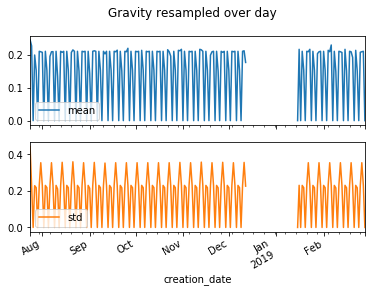

<Figure size 1080x720 with 0 Axes>

In [20]:
r = df['gravity'].resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Gravity resampled over day')
plt.figure(figsize=(15, 10))
plt.show()

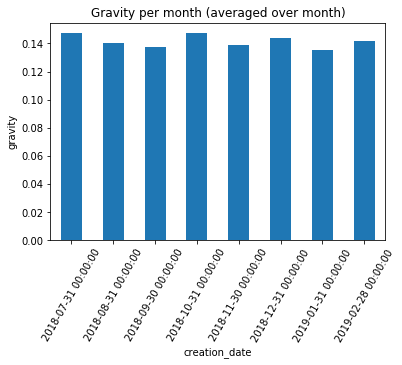

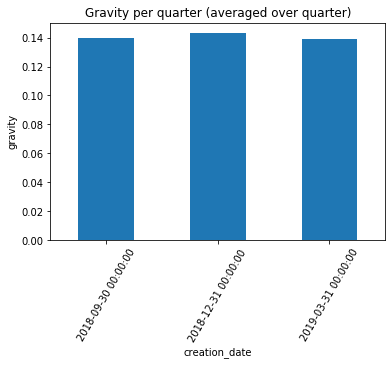

In [34]:
df['gravity'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('gravity')
plt.title('Gravity per month (averaged over month)')
plt.show()

df['gravity'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('gravity')
plt.title('Gravity per quarter (averaged over quarter)')
plt.show()

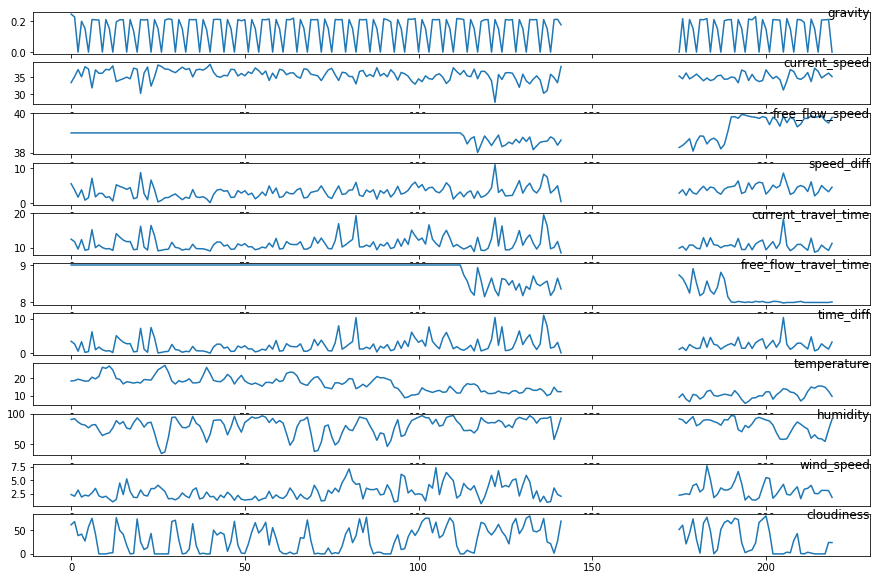

In [23]:
# Below I compare the mean of different featuresresampled over day. 
# specify columns to plot
cols = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]
i = 1
groups=cols
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
    plt.subplot(len(cols), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.75, loc='right')
    i += 1
plt.show()

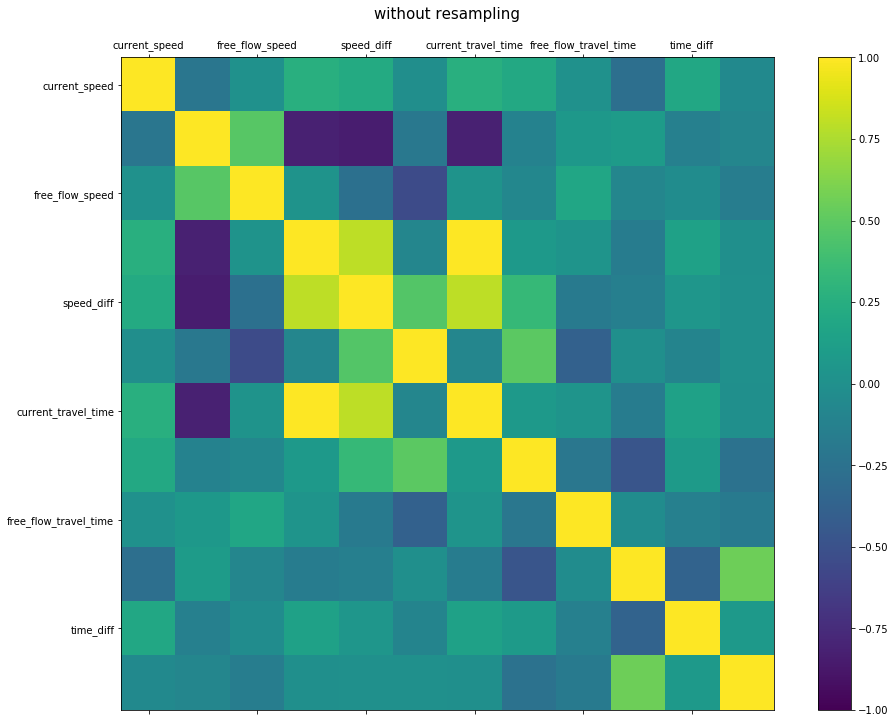

In [24]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr(method='spearman'), vmax=1, vmin=-1)
plt.title('without resampling', size=15)
fig.colorbar(cax)
ax.set_xticklabels(['']+df.columns)
ax.set_yticklabels(['']+df.columns)
plt.show()

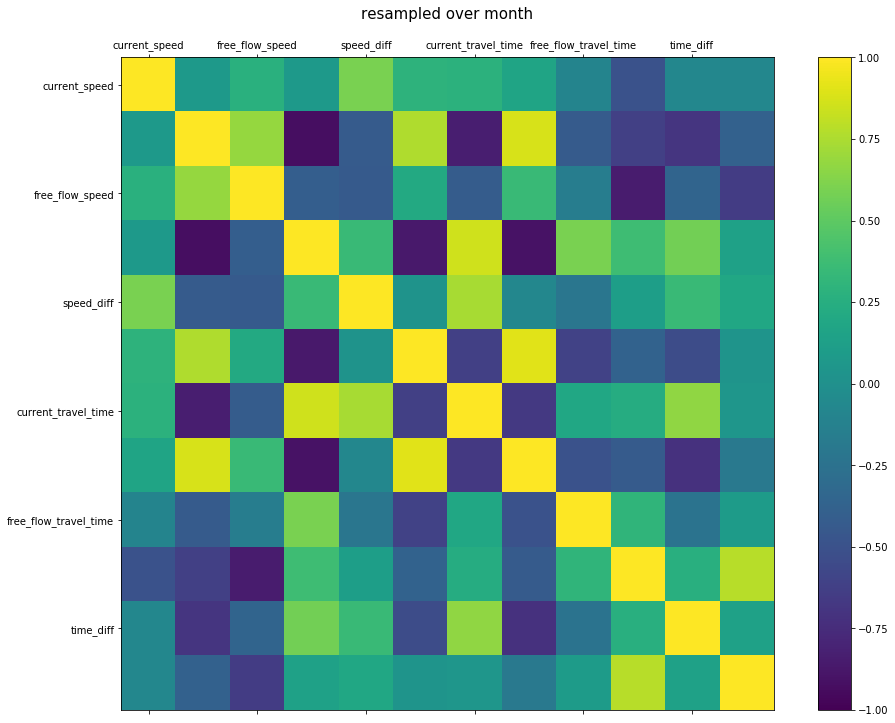

In [25]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
cax = ax.matshow(df.resample('M').mean().corr(method='spearman'), vmax=1, vmin=-1)
plt.title('resampled over month', size=15)
fig.colorbar(cax)
ax.set_xticklabels(['']+df.columns)
ax.set_yticklabels(['']+df.columns)
plt.show()

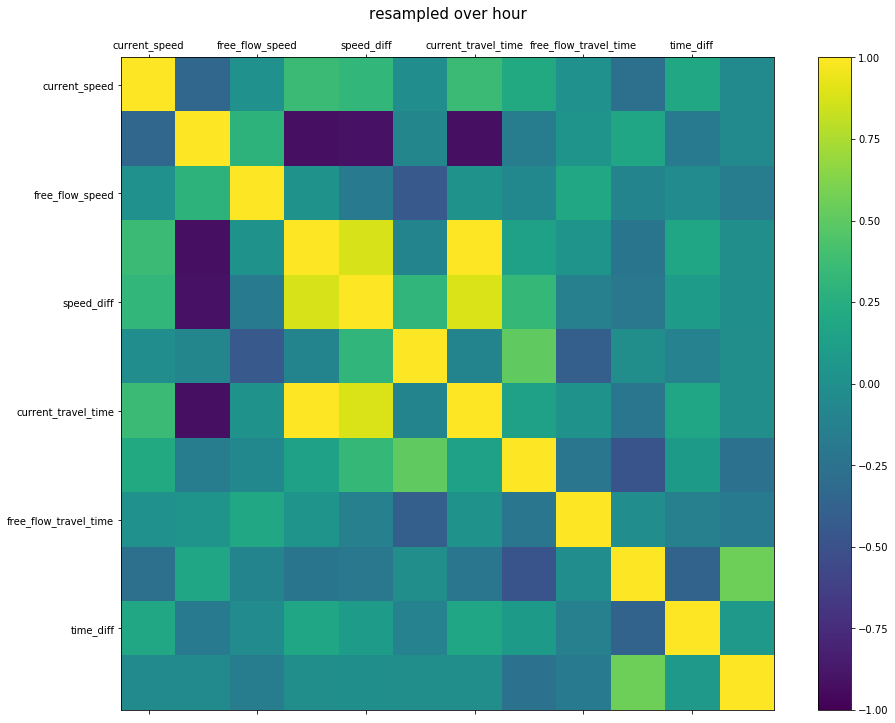

In [26]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
cax = ax.matshow(df.resample('H').mean().corr(method='spearman'), vmax=1, vmin=-1)
plt.title('resampled over hour', size=15)
fig.colorbar(cax)
ax.set_xticklabels(['']+df.columns)
ax.set_yticklabels(['']+df.columns)
plt.show()

In [27]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [28]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(5266, 12)

In [29]:
## * Scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[13,14,15,16,17,18,19,20,21,22,23]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.571429   0.567568   0.470588   0.416667   0.059322        0.8   
2   0.714286   0.972973   0.470588   0.000000   0.008475        0.8   
3   0.714286   0.729730   0.470588   0.250000   0.042373        0.8   
4   1.000000   0.439189   0.470588   0.548611   0.135593        0.8   
5   0.000000   0.722973   0.470588   0.256944   0.067797        0.8   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.051282   0.571429   0.645833    0.732558    0.384615        0.20   
2   0.000000   0.600000   0.645833    0.686047    0.384615        0.20   
3   0.034188   0.542857   0.645833    0.790698    0.307692        0.20   
4   0.128205   0.542857   0.645833    0.790698    0.307692        0.20   
5   0.059829   0.485714   0.645833    0.918605    0.230769        0.75   

    var1(t)  
1  0.714286  
2  0.714286  
3  1.000000  
4  0.000000  
5  0.000000  


In [30]:
# split into train and test sets
values = reframed.values

n_train_time = 365*10
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(3650, 1, 12) (3650,) (778, 1, 12) (778,)


Train on 3650 samples, validate on 778 samples
Epoch 1/20
3650/3650 [==============================] - 1s 215us/sample - loss: 0.0374 - val_loss: 0.0308
Epoch 2/20
3650/3650 [==============================] - 0s 45us/sample - loss: 0.0282 - val_loss: 0.0250
Epoch 3/20
3650/3650 [==============================] - 0s 51us/sample - loss: 0.0242 - val_loss: 0.0231
Epoch 4/20
3650/3650 [==============================] - 0s 49us/sample - loss: 0.0234 - val_loss: 0.0231
Epoch 5/20
3650/3650 [==============================] - 0s 49us/sample - loss: 0.0225 - val_loss: 0.0225
Epoch 6/20
3650/3650 [==============================] - 0s 45us/sample - loss: 0.0226 - val_loss: 0.0224
Epoch 7/20
3650/3650 [==============================] - 0s 45us/sample - loss: 0.0223 - val_loss: 0.0234
Epoch 8/20
3650/3650 [==============================] - 0s 47us/sample - loss: 0.0224 - val_loss: 0.0223
Epoch 9/20
3650/3650 [==============================] - 0s 47us/sample - loss: 0.0222 - val_loss: 0.0221
Epoch 1

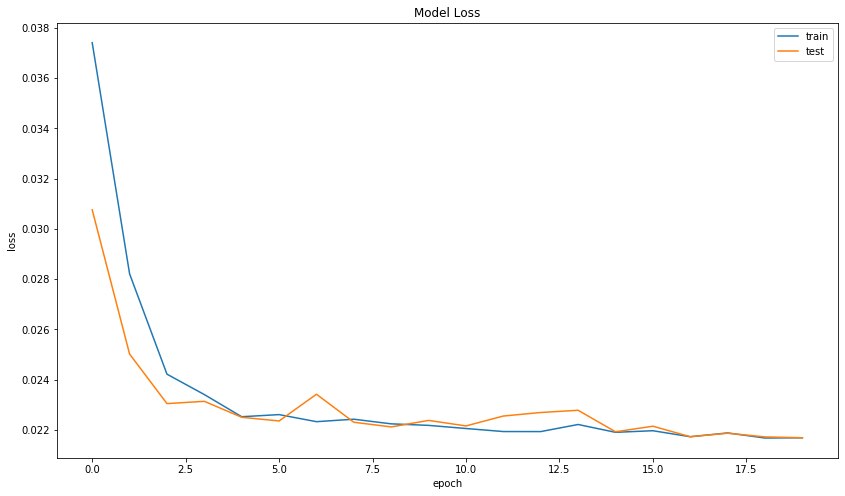

Test RMSE: 0.172


In [31]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=1, shuffle=True)

# summarize history for loss
plt.figure(figsize=(14,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 12))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -11:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -11:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

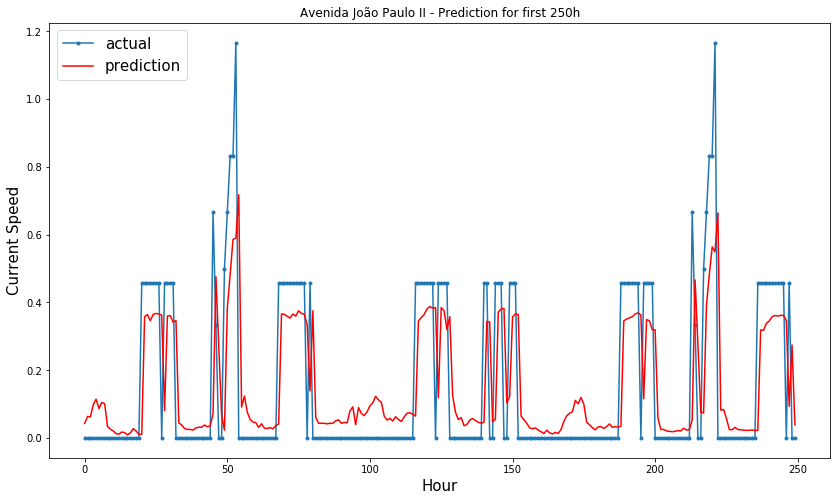

In [32]:
plt.figure(figsize=(14,8))
plt.title('Avenida João Paulo II - Prediction for first 250h')

aa=[x for x in range(250)]

plt.plot(aa, inv_y[:250], marker='.', label="actual")
plt.plot(aa, inv_yhat[:250], 'r', label="prediction")
plt.ylabel('Current Speed', size=15)
plt.xlabel('Hour', size=15)
plt.legend(fontsize=15)
plt.show()